# seq2seq tutorial

https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb

In [1]:
x = [[5,7,8],[6,3],[3],[1]]

In [79]:
# import helpers
import numpy as np

def helper_batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths


def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]

In [5]:
xt, xlen = batch(x)

In [6]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [7]:
xlen

[3, 2, 1, 1]

## モデルを作る

In [46]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

/Users/jun/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [47]:
tf.__version__

'1.8.0-rc0'

## モデルの入力と出力

デコードで最初に大事になるのは「語彙の数」です．

In [48]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

複雑な関数を理解するのに良い方法はその様相を観察することです．つまり入力と出力に気をつけます．

In [49]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_input')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [50]:
decoder_inputs = tf.placeholder(shape=(None,None), dtype=tf.int32, name='decoder_inputs')

## Embeddings

In [51]:
embeddings = tf.Variable(
    tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
    dtype=tf.float32)

In [52]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

## Encoder

In [53]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32,
    time_major=True,
)

del encoder_outputs

In [54]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>)

## Decoder

In [55]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32,
    time_major=True,
    scope='plain_decoder'
)

In [56]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

In [57]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

In [62]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [63]:
sess.run(tf.global_variables_initializer())

### Test florward pass

In [66]:
batch_ = [[6],[3,4],[9,8,7]]

batch_, batch_length_ = batch(batch_)
print('batch_encoded: \n', batch_)

din_, dlen_ = batch(np.ones(shape=(3,1), dtype=np.int32),
                   max_sequence_length=4)
print('decoder inputs:\n', din_)

pred_ = sess.run(decoder_prediction,
               feed_dict={
                   encoder_inputs: batch_,
                   decoder_inputs: din_,
               })
print('decoder predictions:\n', pred_)

batch_encoded: 
 [[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
 [[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
 [[9 3 9]
 [1 3 6]
 [1 1 1]
 [1 1 1]]


### Training on the toy task

In [67]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=8,
                          vocab_lower=2, vocab_upper=10,
                          batch_size=batch_size)
print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 8, 7, 5, 7, 7, 8, 2]
[9, 7, 8, 8, 4, 3, 8]
[2, 2, 4, 2]
[5, 9, 6]
[6, 4, 3]
[3, 2, 3, 9, 3]
[3, 4, 9, 4]
[9, 7, 2, 2, 3]
[8, 8, 5, 2, 7]
[8, 5, 9, 5]


In [86]:
def next_feed():
    b = next(batches)
    encoder_inputs_, _ = helper_batch(b)
    decoder_targets_, _ = helper_batch(
        [(sequence) + [EOS] for sequence in b]
    )
    decoder_inputs_, _ = helper_batch(
        [[EOS] + (sequence) for sequence in b]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [87]:
loss_track = []

In [88]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}'.format(i+1))
                print('    input      > {}'.format(inp))
                print('    predicted  > {}'.format(pred))
                if i >= 2:
                    break
                print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.268376350402832
  sample 1
    input      > [3 7 2 4 4 0 0 0]
    predicted  > [4 4 4 2 7 7 1 1 1]

  sample 2
    input      > [6 4 3 8 0 0 0 0]
    predicted  > [4 4 4 4 9 3 1 1 1]

  sample 3
    input      > [6 8 9 5 0 0 0 0]
    predicted  > [9 4 4 4 3 1 1 1 1]
batch 1000
  minibatch loss: 0.2713669538497925
  sample 1
    input      > [9 5 4 7 4 9 5 0]
    predicted  > [9 5 4 7 4 9 5 1 0]

  sample 2
    input      > [4 2 3 8 6 3 7 9]
    predicted  > [4 2 3 8 3 3 7 9 1]

  sample 3
    input      > [5 3 4 5 6 3 0 0]
    predicted  > [5 3 4 5 6 3 1 0 0]
batch 2000
  minibatch loss: 0.12692590057849884
  sample 1
    input      > [2 2 7 2 0 0 0 0]
    predicted  > [2 2 7 2 1 0 0 0 0]

  sample 2
    input      > [3 2 4 0 0 0 0 0]
    predicted  > [3 2 4 1 0 0 0 0 0]

  sample 3
    input      > [2 5 9 7 8 9 0 0]
    predicted  > [2 5 9 7 8 9 1 0 0]
batch 3000
  minibatch loss: 0.08766920119524002
  sample 1
    input      > [8 9 7 5 2 9 6 0]
    predict

loss 0.0863 after 300100 examples (batch_size=100)


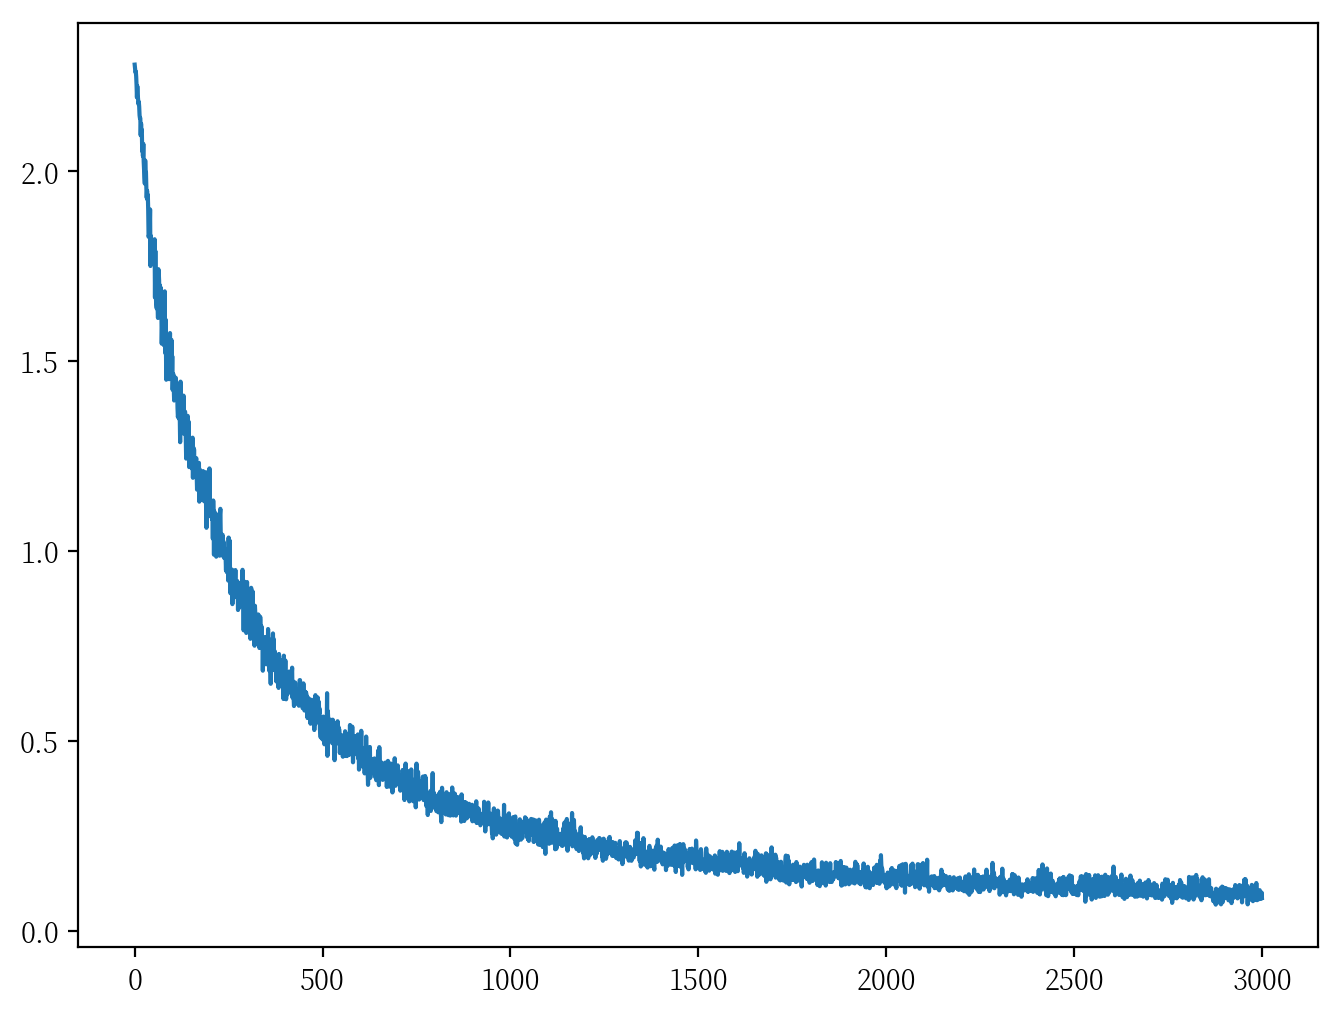

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))